In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
from geopy import distance
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [2]:
train = pd.read_csv('/Users/guanlxy/Documents/github/ids-705-final-project/data/processed/train.csv')
train.shape

(74111, 43)

In [3]:
train1 = train.copy()
train1 = train1.drop(columns=['capital','amenities','description','name','neighbourhood',
                             'thumbnail_url','zipcode','city_name','country','iso2','iso3'])

## Finding the null values.
print(train1.isnull().sum())

Unnamed: 0                    0
id                            0
log_price                     0
property_type                 0
room_type                     0
accommodates                  0
bathrooms                   200
bed_type                      0
cancellation_policy           0
cleaning_fee                  0
city                          0
first_review              15864
host_has_profile_pic        188
host_identity_verified      188
host_response_rate        18299
host_since                  188
instant_bookable              0
last_review               15827
latitude                      0
longitude                     0
number_of_reviews             0
review_scores_rating      16722
bedrooms                     91
beds                        131
city_id                       0
city_ascii                    0
lat                           0
lng                           0
admin_name                    0
population                    0
cc_dist                       0
num_bnb_

In [4]:
#percentage to float
train1['host_response_rate'] = train1['host_response_rate'].str.rstrip('%').astype('float')

In [5]:
#string to time
train1['first_review'] = pd.to_datetime(train1['first_review'])
train1['host_since'] = pd.to_datetime(train1['host_since'])
train1['last_review'] = pd.to_datetime(train1['last_review'])

In [6]:
#back impute
train2 = train1.fillna(method='bfill')

In [7]:
#Imputer

from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with median of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

In [8]:
train_imp = DataFrameImputer().fit_transform(train1)

In [9]:
cate_vari = ['property_type','room_type','bed_type','cancellation_policy','cleaning_fee','city',
             'host_has_profile_pic','host_identity_verified','instant_bookable','city_ascii',
            'admin_name']
for i in cate_vari:
    #train[i]=train[i].astype(str)
    train_imp[i]=pd.Categorical(train_imp[i])

In [10]:
train_imp['first_review'] = pd.to_datetime(train_imp['first_review']).astype(np.int)/100000000000
train_imp['host_since'] = pd.to_datetime(train_imp['host_since']).astype(np.int)/1000000000000
train_imp['last_review'] = pd.to_datetime(train_imp['last_review']).astype(np.int)/1000000000000

In [11]:
train_imp.dtypes

Unnamed: 0                   int64
id                           int64
log_price                  float64
property_type             category
room_type                 category
accommodates                 int64
bathrooms                  float64
bed_type                  category
cancellation_policy       category
cleaning_fee              category
city                      category
first_review               float64
host_has_profile_pic      category
host_identity_verified    category
host_response_rate         float64
host_since                 float64
instant_bookable          category
last_review                float64
latitude                   float64
longitude                  float64
number_of_reviews            int64
review_scores_rating       float64
bedrooms                   float64
beds                       float64
city_id                      int64
city_ascii                category
lat                        float64
lng                        float64
admin_name          

In [12]:
#one hot encoding for categorical variables
from sklearn.preprocessing import OneHotEncoder

# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')
# passing column (label encoded values)
train_imp_ohe = pd.DataFrame(enc.fit_transform(train_imp[cate_vari]).toarray())

train_imp_ohe.columns = enc.get_feature_names()
# merge with main df bridge_df on key values
train_impp = train_imp.join(train_imp_ohe)


train_impp.drop(columns=cate_vari, inplace=True)
train_impp.drop(columns=['Unnamed: 0','id'], inplace=True)

In [28]:
y_imp = train_impp.log_price
X_imp = train_impp.drop(columns=['log_price'])

X_imp = (X_imp - X_imp.mean()) / X_imp.std()

r_state = 2021

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X_imp, y_imp, test_size=0.2, random_state=r_state)

In [29]:
X_train.columns

Index(['accommodates', 'bathrooms', 'first_review', 'host_response_rate',
       'host_since', 'last_review', 'latitude', 'longitude',
       'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds',
       'city_id', 'lat', 'lng', 'population', 'cc_dist', 'num_bnb_1km',
       'x0_Apartment', 'x0_Bed & Breakfast', 'x0_Boat', 'x0_Boutique hotel',
       'x0_Bungalow', 'x0_Cabin', 'x0_Camper/RV', 'x0_Casa particular',
       'x0_Castle', 'x0_Cave', 'x0_Chalet', 'x0_Condominium', 'x0_Dorm',
       'x0_Earth House', 'x0_Guest suite', 'x0_Guesthouse', 'x0_Hostel',
       'x0_House', 'x0_Hut', 'x0_In-law', 'x0_Island', 'x0_Lighthouse',
       'x0_Loft', 'x0_Other', 'x0_Parking Space', 'x0_Serviced apartment',
       'x0_Tent', 'x0_Timeshare', 'x0_Tipi', 'x0_Townhouse', 'x0_Train',
       'x0_Treehouse', 'x0_Vacation home', 'x0_Villa', 'x0_Yurt',
       'x1_Entire home/apt', 'x1_Private room', 'x1_Shared room', 'x2_Airbed',
       'x2_Couch', 'x2_Futon', 'x2_Pull-out Sofa', 'x2_Real B

array([0.10942889, 0.16850403, 0.21120261, 0.24868589, 0.2844001 ,
       0.31815734, 0.3475456 , 0.37211658, 0.39457859, 0.41663631,
       0.4375101 , 0.45590852, 0.47256275, 0.48818912, 0.50222801,
       0.51616114, 0.53004004, 0.54391662, 0.55776724, 0.57161211,
       0.58543762, 0.59909378, 0.61265045, 0.62545851, 0.63775058,
       0.6496875 , 0.66156879, 0.67330001, 0.68499573, 0.69662354,
       0.70817842, 0.7196714 , 0.73107999, 0.74241796, 0.75368392,
       0.76492124, 0.77609725, 0.78723936, 0.79832314, 0.80933973,
       0.82032566, 0.83123856, 0.84208235, 0.85281373, 0.86348975,
       0.87409384, 0.88437104, 0.89439367, 0.90428223, 0.914112  ,
       0.92380017, 0.93334475, 0.9421411 , 0.95078186, 0.95936177,
       0.96773909, 0.97484525, 0.98136746, 0.98670825, 0.99186389,
       0.99519728, 0.99811778, 0.99999524, 0.99999987, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

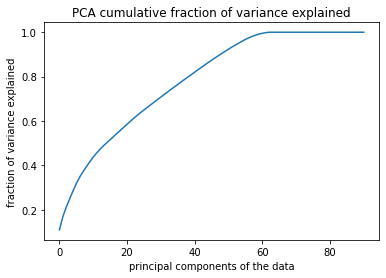

In [42]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import (KNeighborsClassifier, NeighborhoodComponentsAnalysis)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


#figure out how much dimension we need after pca
pca = PCA(n_components=X_train.shape[1])
pca_transform = pca.fit_transform(X_train,y_train)
var_values = pca.explained_variance_ratio_


cum_exp_variance = np.cumsum(var_values)
plt.plot(cum_exp_variance)
plt.xlabel('principal components of the data')
plt.ylabel('fraction of variance explained')
plt.title('PCA cumulative fraction of variance explained')

cum_exp_variance

In [39]:
# Reduce dimension to 2/5/15 with PCA
pca_2 = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=r_state))
pca_15 = make_pipeline(StandardScaler(), PCA(n_components=15, random_state=r_state))
pca_40 = make_pipeline(StandardScaler(), PCA(n_components=40, random_state=r_state))


In [40]:
# Make a list of the methods to be compared
dim_reduction_methods = [('PCA2', pca_2),('PCA15', pca_15),('PCA40', pca_40)]

In [34]:
# Use a nearest neighbor classifier to evaluate the methods
import time
from sklearn.neighbors import KNeighborsRegressor
n_neighbors=5
knn = KNeighborsRegressor(n_neighbors=n_neighbors)

In [41]:
for i, (name, model) in enumerate(dim_reduction_methods):
    
    #start timer
    time0 = time.time()
    # Fit the method's model
    model.fit(X_train, y_train)

    # Fit a nearest neighbor classifier on the embedded training set
    knn.fit(model.transform(X_train), y_train)
    #time for training
    time1 = time.time()
    
    # Compute the nearest neighbor accuracy on the embedded test set
    acc_knn = knn.score(model.transform(X_test), y_test)
    #time for test
    time2 = time.time()
    
    print("{}, KNN (k={})\nTest score = {:.2f}".format(name,n_neighbors,acc_knn))
    print('KNN ({}) training time = {}, prediction time ={}'.format(name,time1-time0,time2-time1))

PCA2, KNN (k=5)
Test score = 0.31
KNN (PCA2) training time = 0.431812047958374, prediction time =0.07325387001037598
PCA15, KNN (k=5)
Test score = 0.53
KNN (PCA15) training time = 0.5479950904846191, prediction time =2.4731757640838623
PCA40, KNN (k=5)
Test score = 0.52
KNN (PCA40) training time = 0.7005209922790527, prediction time =17.881527185440063


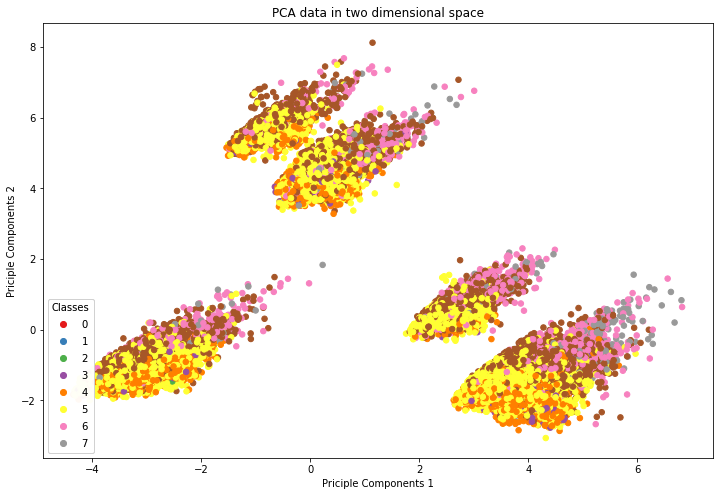

In [43]:
# Fit the method's model
pca_2.fit(X_train,y_train)

# Embed the data set in 2 dimensions using the fitted model
X_embedded = pca_2.transform(X_train)

# Plot the projected points and show the evaluation score
fig, ax = plt.subplots(figsize=(12,8))
scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train, s=30, cmap='Set1')
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.xlabel('Priciple Components 1')
plt.ylabel('Priciple Components 2')
plt.title('PCA data in two dimensional space')
plt.show()